#Dependencies

In [7]:
# pip install lime


In [ ]:
!pip install -q optuna


In [1]:
 !pip install -q -U bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 55.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
mlxtend 0.23.3 requires scik

In [9]:
# !gdown 1y6R4r2azEusl4bLyussZcZvo3-wI3dCn

In [10]:
# !pip install fasttext

In [2]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from bnlp import BasicTokenizer
from bnlp import SentencepieceTokenizer
from bnlp import BengaliWord2Vec
from bnlp import NLTKTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support


In [60]:
df = pd.read_csv("/kaggle/input/hate-speech/dataset/train.csv")


#Cleaning

In [61]:
def clean_text(text):
    # Emoji removal pattern covering various emoji ranges
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove English characters & numbers
    text = re.sub(r'[A-Za-z0-9]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]০১২৩৪৫৬৭৮৯', '', text)
    punctuations = '''`|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    # Create a character class to remove specified characters
    regex_pattern = '[' + re.escape(punctuations) + ']'
    text = re.sub(regex_pattern, '', text)


    return text



In [62]:
df['sentence'] = df['sentence'].apply(clean_text)


In [ ]:
df = df.drop(columns=['hate speech','target'])

#Describe Dataset

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40224 entries, 0 to 40223
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  40224 non-null  object
 1   type      19324 non-null  object
dtypes: object(2)
memory usage: 628.6+ KB


In [66]:
df.isnull().sum()

sentence        0
type        20900
dtype: int64

In [67]:
df.head()

,sentence,type
0,ঐ ইন্দুর তোই মরছ নাই,callToViolence
1,গেবনের শেষে আইসা আপনার মুখোশ টা খুলছে এতেই আমি...,callToViolence
2,মুরগি চোরের পাছায় ডুকবি আর মারবি,callToViolence
3,কোটির চোদা খাওয়া শেষে এখন কোটির চোদা খাবে মিথিলা,callToViolence
4,য় মীর জাফরের মুখে মুতে দে,callToViolence


In [59]:
target_counts

,target,count
0,ind,7057
1,male,5413
2,female,4093
3,group,2486
4,male_female,225
5,female_group,18
6,male_group,13
7,ind_female,10
8,ind_group,5
9,male_female_group,3


In [73]:
import plotly.express as px

# Plot the distribution of 'target'
target_counts = df['type'].value_counts().reset_index()
target_counts.columns = ['type', 'count']  # Rename the columns for clarity

fig_target = px.bar(target_counts, 
                    x='type', 
                    y='count', 
                    labels={'type': 'Type', 'count': 'Count'},
                    title="Distribution of Type",
                    color='type', 
                    color_continuous_scale='Viridis')

# Use `fig.show()` to explicitly display the plot
fig_target.show()

In [75]:
df['type'].fillna('0', inplace=True) # Replace null values with 0
df.isnull().sum() 


sentence    0
type        0
dtype: int64

In [76]:
type_unique = df['type'].nunique() # Number of unique classes
type_unique

16

In [78]:
distinct_classes = df['type'].unique() # Get all unique classes
distinct_classes


array(['callToViolence', 'callToViolence_gender',
       'callToViolence_religion', 'callToViolence_slander',
       'callToViolence_religion_slander', 'slander', 'gender_slander',
       'callToViolence_gender_slander', 'religion_slander', 'gender',
       'callToViolence_gender_religion', 'gender_religion', 'religion',
       'callToViolence_gender_religion_slander',
       'gender_religion_slander', '0'], dtype=object)

In [79]:
class_mapping = {
    '0': 0,
    'callToViolence': 1,
    'callToViolence_gender': 2,
    'callToViolence_religion': 3,
    'callToViolence_slander': 4,
    'callToViolence_religion_slander': 5,
    'slander': 6,
    'gender_slander': 7,
    'callToViolence_gender_slander': 8,
    'religion_slander': 9,
    'gender': 10,
    'callToViolence_gender_religion': 11,
    'gender_religion': 12,
    'religion': 13,
    'callToViolence_gender_religion_slander': 14,
    'gender_religion_slander': 15
}

# Apply the mapping to the 'type' column
df['encoded_type'] = df['type'].map(class_mapping)

# Verify the encoding
df[['type', 'encoded_type']].head(50)

,type,encoded_type
0,callToViolence,1
1,callToViolence,1
2,callToViolence,1
3,callToViolence,1
4,callToViolence,1
5,callToViolence,1
6,callToViolence,1
7,callToViolence,1
8,callToViolence,1
9,callToViolence,1


In [81]:
distinct_classes = df['type'].unique()
distinct_classes

array(['callToViolence', 'callToViolence_gender',
       'callToViolence_religion', 'callToViolence_slander',
       'callToViolence_religion_slander', 'slander', 'gender_slander',
       'callToViolence_gender_slander', 'religion_slander', 'gender',
       'callToViolence_gender_religion', 'gender_religion', 'religion',
       'callToViolence_gender_religion_slander',
       'gender_religion_slander', '0'], dtype=object)

In [20]:
print(df['sentence'].iloc[2],"\n")
print(df['sentence'].iloc[4],"\n")

মুরগি চোরের পাছায় ডুকবি আর মারবি 

য় মীর জাফরের মুখে মুতে দে 



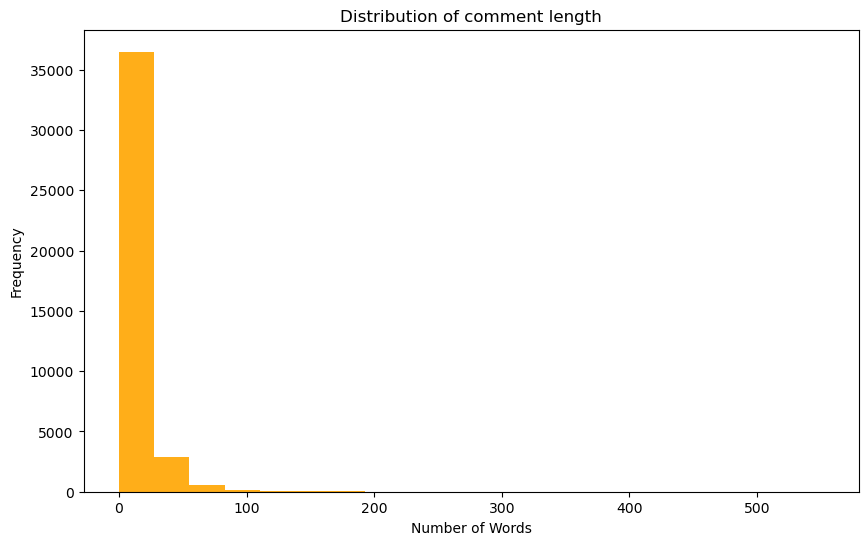

In [21]:
word_counts = df['sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, color='orange', alpha=0.9)
plt.title('Distribution of comment length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#Tokenization

Tokenize

In [82]:
basic_tokenizer = BasicTokenizer()

df['sentence'] = df['sentence'].apply(basic_tokenizer.tokenize)

In [54]:
df.head(50)

,index,sentence,target,encoded_target
0,0,ঐ ইন্দুর তোই মরছ নাই,ind,1
1,1,গেবনের শেষে আইসা আপনার মুখোশ টা খুলছে এতেই আমি...,ind,1
2,2,মুরগি চোরের পাছায় ডুকবি আর মারবি,ind,1
3,3,কোটির চোদা খাওয়া শেষে এখন কোটির চোদা খাবে মিথিলা,female,2
4,4,য় মীর জাফরের মুখে মুতে দে,male,3
5,5,অই কখানকি সত্যি বলতে কি জানছ তরে জুদি পাইতাম ত...,female,2
6,6,অই জারছি পরা লোক টা কে পাইলে কোত্তার মতো পিটাইতাম,ind,1
7,7,অকে পিথিবির আলো দেখানোর আগেই মেরে ফেলা দরকার ছিল,ind,1
8,8,অকে মেরে ফেলতে হবে,ind,1
9,9,অগরে চুদে মেয়ে গূলোকে,group,4


Tf-idf

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df['sentence'] = df['sentence'].apply(lambda x: ' '.join(x))  # Join tokens into a single string

# Apply TfidfVectorizer with unigram and bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, tokenizer=lambda x: x.split())

# Apply TF-IDF to the joined (space-separated) text data
x_tfidf_bigram = tfidf_bigram.fit_transform(df['sentence'])

# If you have labels in 'hate speech' column
X_train, X_test, y_train, y_test = train_test_split(x_tfidf_bigram, df['type'], test_size=0.2, random_state=42)


Evaluator

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X_test, y_test):
    # Model type display
    print(70*'-')
    print(f"Evaluating model: {model.__class__.__name__}")
    
    # Predict the results
    y_pred = model.predict(X_test)
    
    # For multiclass, we use label_binarize to get binary relevance for each class
    class_labels = ['0', 'callToViolence', 'callToViolence_gender', 'callToViolence_religion', 
                    'callToViolence_slander', 'callToViolence_religion_slander', 'slander', 
                    'gender_slander', 'callToViolence_gender_slander', 'religion_slander', 
                    'gender', 'callToViolence_gender_religion', 'gender_religion', 
                    'religion', 'callToViolence_gender_religion_slander', 'gender_religion_slander']

    # Binarize the true and predicted labels for multiclass
    y_test_bin = label_binarize(y_test, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
    recall = recall_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
    f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro' or 'weighted'
    
    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1 Score (macro): {f1:.4f}')
    
    # Generate the confusion matrix for multiclass
    cm = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # ROC Curve and AUC for multiclass classification (one-vs-rest approach)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(12, 10))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.4f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print(70*'-')


Train & evaluate

random forest

----------------------------------------------------------------------
Evaluating model: RandomForestClassifier
Accuracy: 0.7115
Precision (macro): 0.3638
Recall (macro): 0.1806
F1 Score (macro): 0.2042


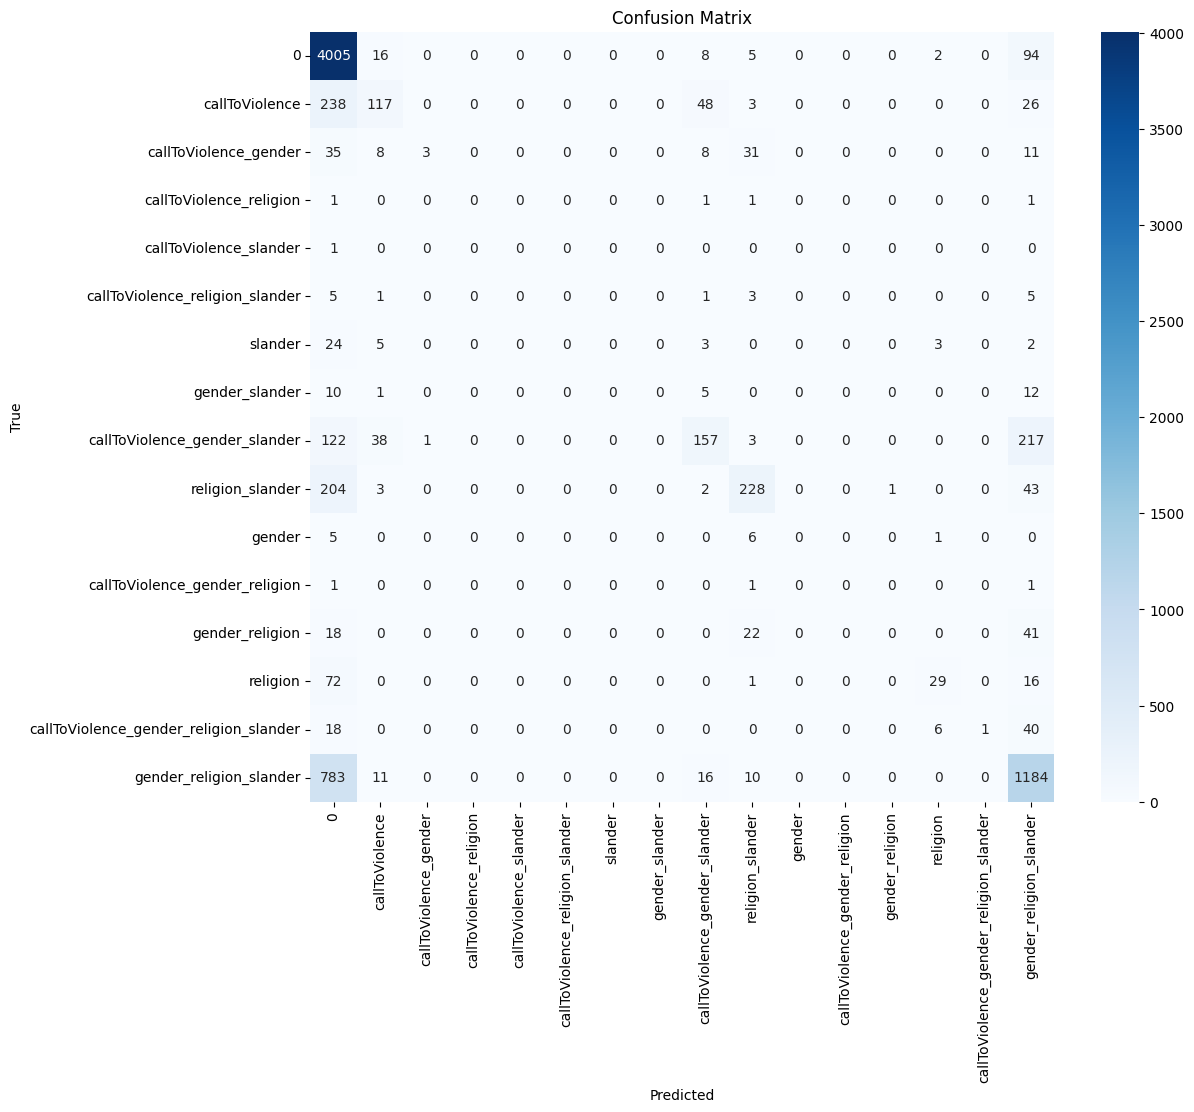

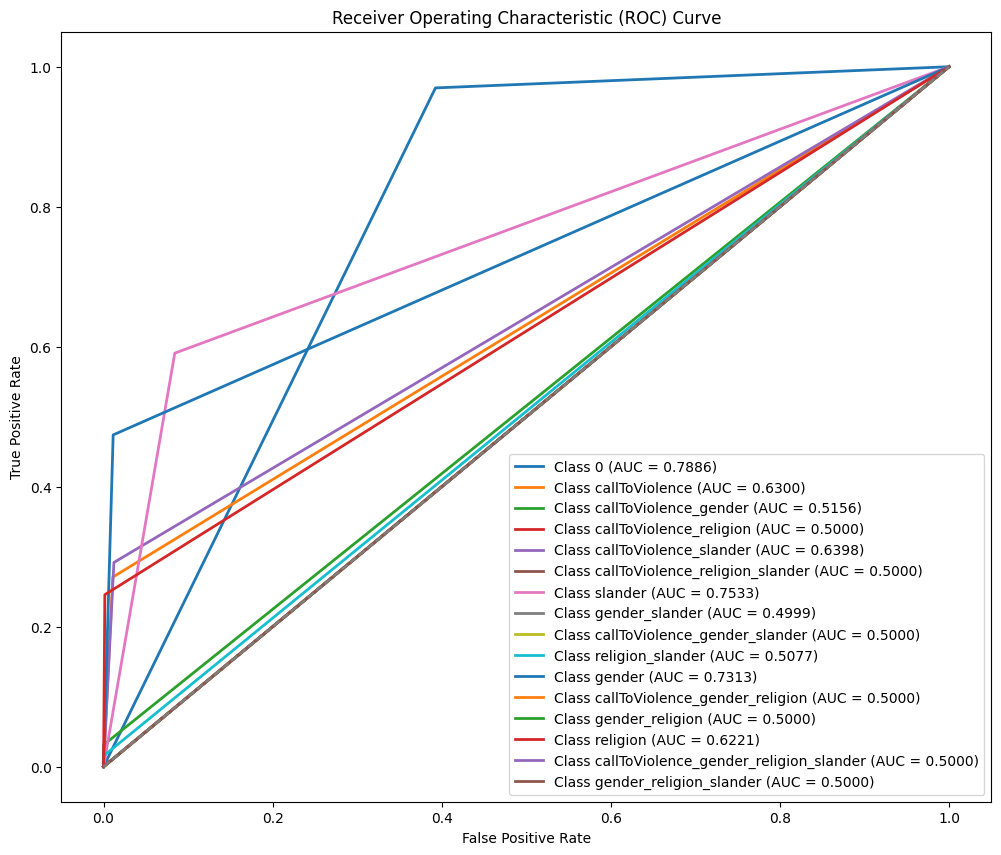

----------------------------------------------------------------------


In [87]:
model_rf = RandomForestClassifier(random_state=42 )
model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_test, y_test)

logistic regression

----------------------------------------------------------------------
Evaluating model: LogisticRegression
Accuracy: 0.7027
Precision (macro): 0.3747
Recall (macro): 0.1694
F1 Score (macro): 0.1922


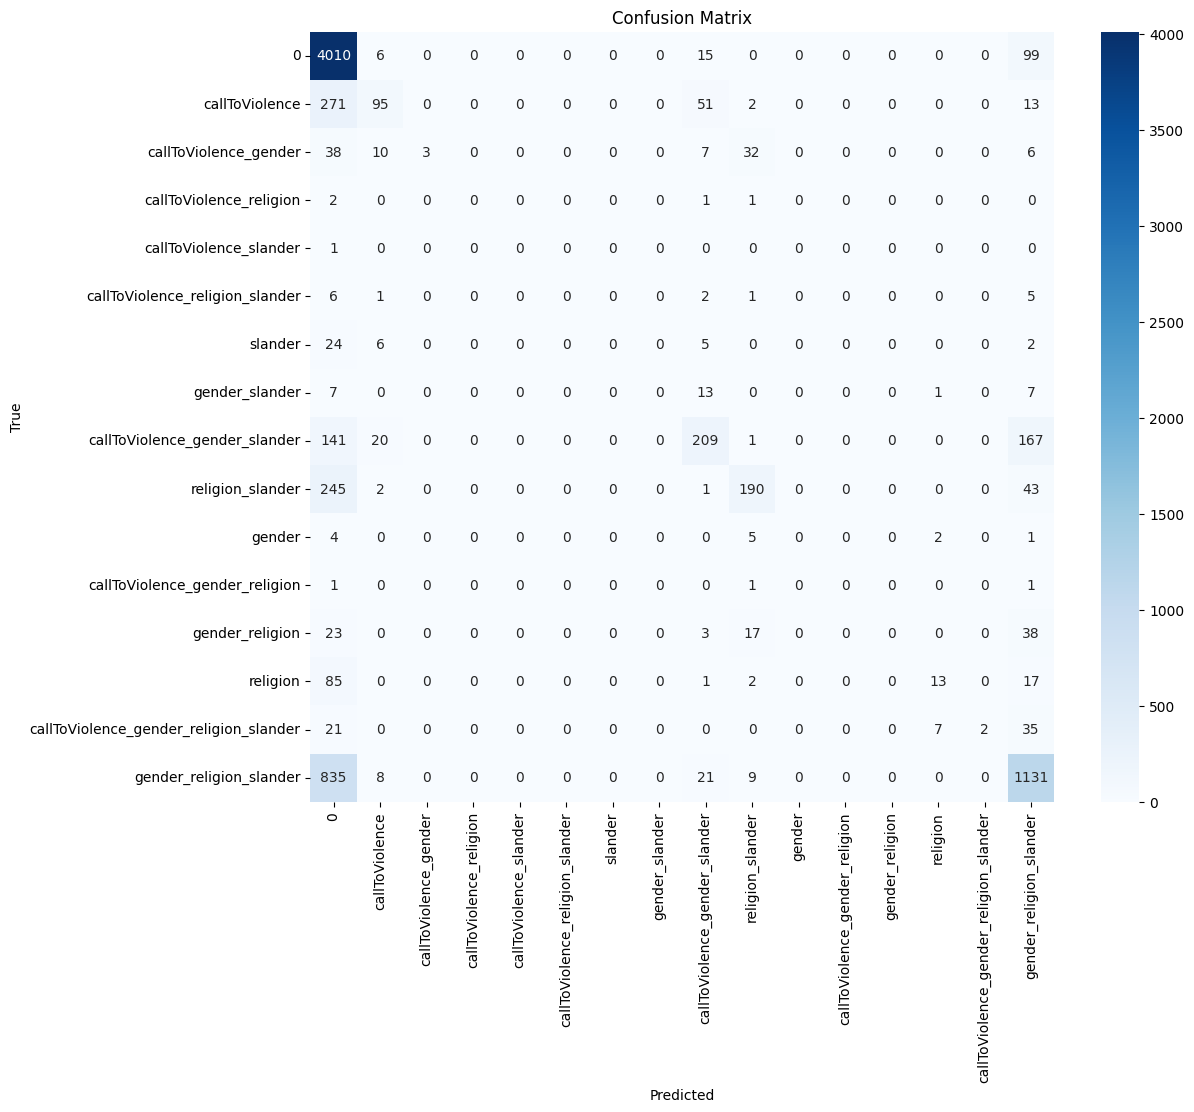

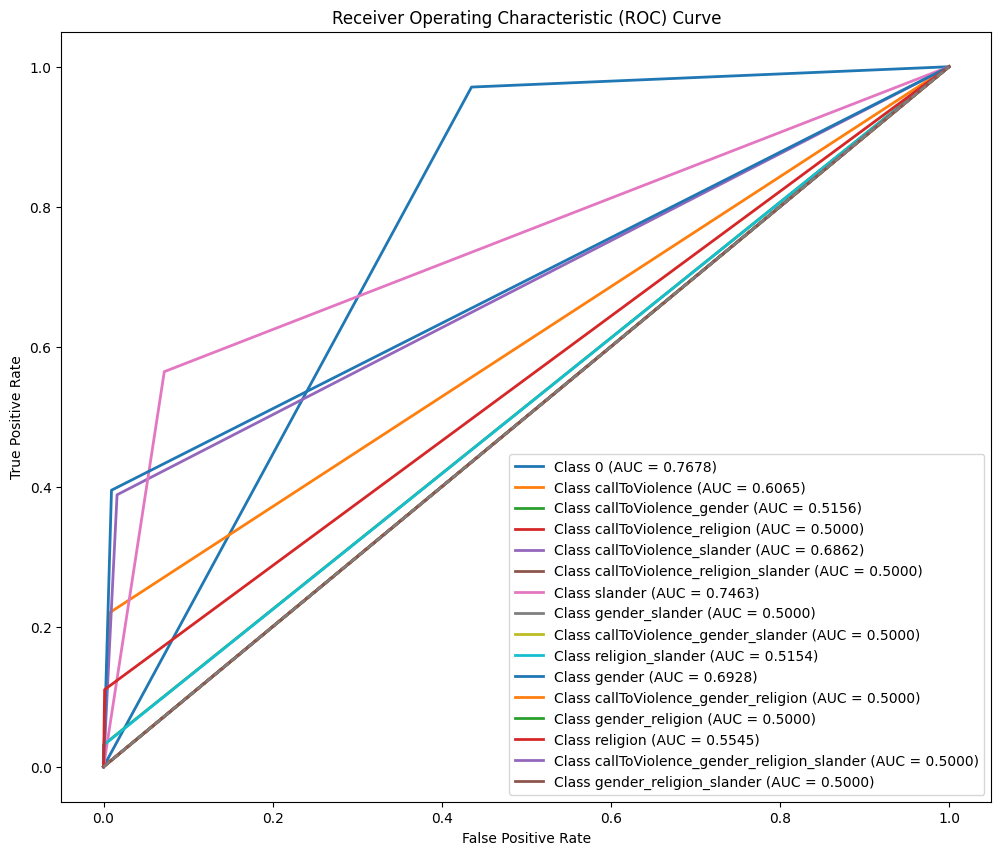

----------------------------------------------------------------------


In [86]:
model_lr = LogisticRegression(penalty='l2',random_state=0)
model_lr.fit(X_train, y_train)
evaluate_model(model_lr, X_test, y_test)

knn

----------------------------------------------------------------------
Evaluating model: KNeighborsClassifier
Accuracy: 0.5195
Precision (macro): 0.2324
Recall (macro): 0.0665
F1 Score (macro): 0.0505


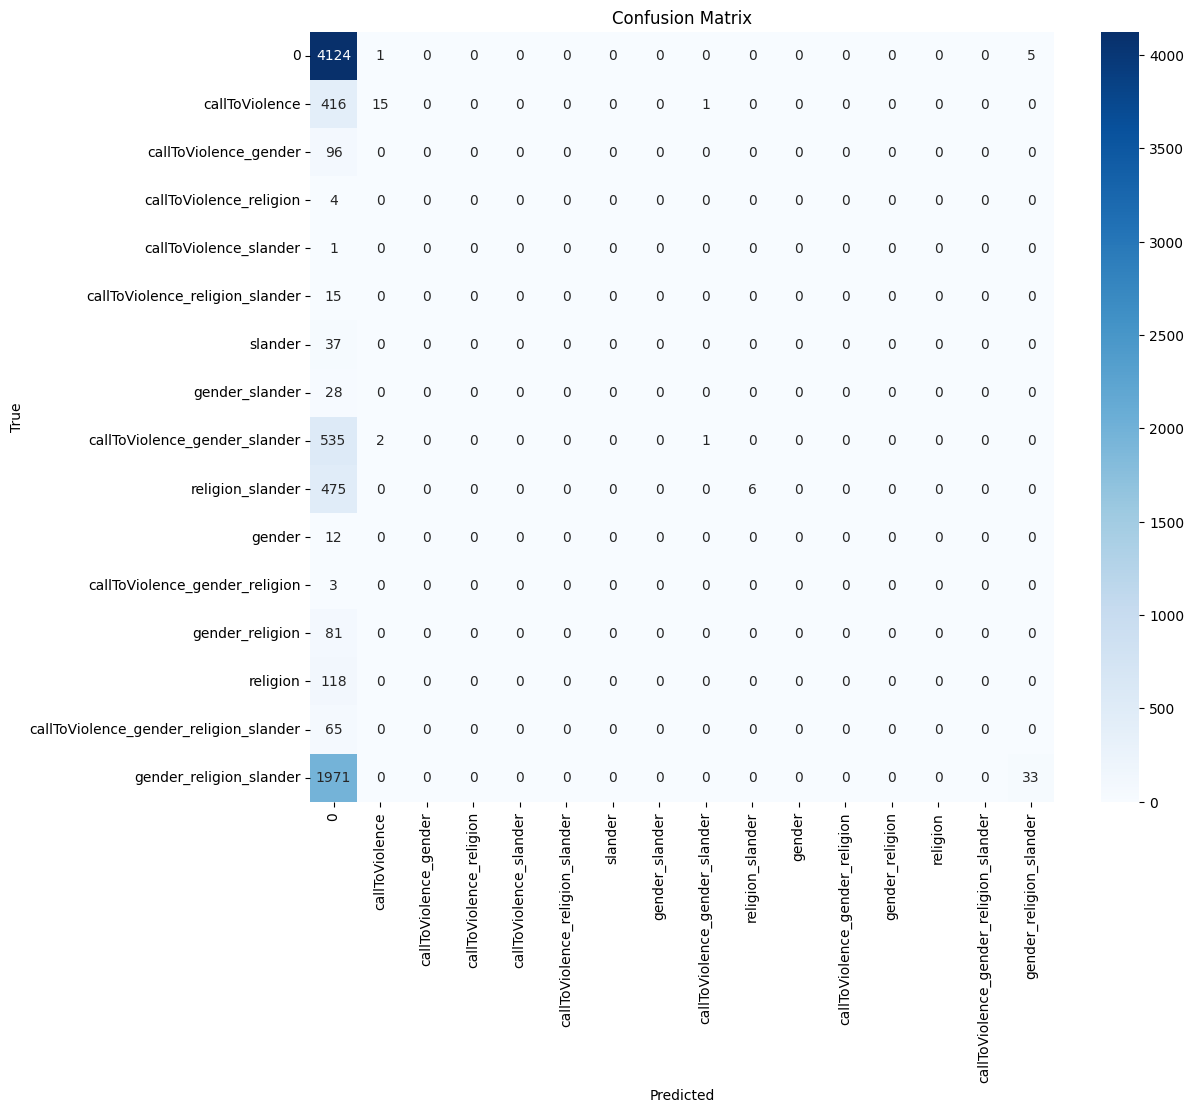

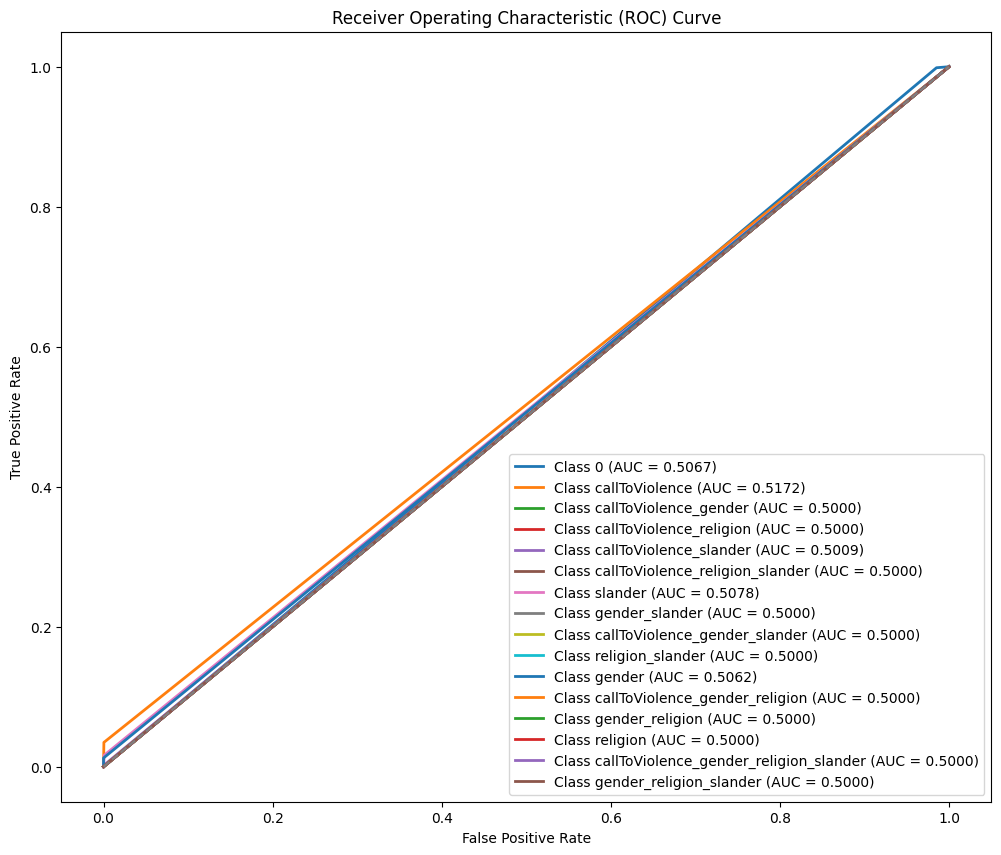

----------------------------------------------------------------------


In [88]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model_knn.fit(X_train, y_train)
evaluate_model(model_knn, X_test, y_test)

svm